In [1]:
from google.colab import drive
drive.mount('/content/drive')



Mounted at /content/drive


In [2]:
!pip install tensorflow opencv-python matplotlib


In [3]:
import os
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.layers import (
    Conv2D, MaxPooling2D, UpSampling2D, Concatenate, Input, Activation, Multiply, Add
)
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import load_img, img_to_array



In [24]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Concatenate, Input, BatchNormalization, Dropout, LeakyReLU
from tensorflow.keras.models import Model

#Attention Gate Function
def attention_gate(skip_connection, gating_signal):
    shape = tf.keras.backend.int_shape(skip_connection)

    theta_x = Conv2D(shape[-1], (1,1), padding="same")(gating_signal)  # Reduce channels
    phi_g = Conv2D(shape[-1], (1,1), padding="same")(skip_connection)  # Reduce channels

    add = tf.keras.layers.Add()([theta_x, phi_g])
    act = LeakyReLU()(add)
    psi = Conv2D(1, (1,1), activation='sigmoid', padding="same")(act)  # Attention mask
    psi = tf.keras.layers.Multiply()([skip_connection, psi])  # Apply mask

    return psi

# Fine-Tuned U-Net with Attention
def unet_with_attention(input_shape=(256, 256, 3)):
    inputs = Input(input_shape)

    # Encoder
    c1 = Conv2D(64, (3,3), padding='same')(inputs)
    c1 = BatchNormalization()(c1)
    c1 = LeakyReLU()(c1)
    c1 = Conv2D(64, (3,3), padding='same')(c1)
    c1 = BatchNormalization()(c1)
    c1 = LeakyReLU()(c1)
    p1 = MaxPooling2D((2,2))(c1)

    c2 = Conv2D(128, (3,3), padding='same')(p1)
    c2 = BatchNormalization()(c2)
    c2 = LeakyReLU()(c2)
    c2 = Conv2D(128, (3,3), padding='same')(c2)
    c2 = BatchNormalization()(c2)
    c2 = LeakyReLU()(c2)
    p2 = MaxPooling2D((2,2))(c2)

    c3 = Conv2D(256, (3,3), padding='same')(p2)
    c3 = BatchNormalization()(c3)
    c3 = LeakyReLU()(c3)
    c3 = Conv2D(256, (3,3), padding='same')(c3)
    c3 = BatchNormalization()(c3)
    c3 = LeakyReLU()(c3)
    p3 = MaxPooling2D((2,2))(c3)

    # Bottleneck
    c4 = Conv2D(512, (3,3), padding='same')(p3)
    c4 = BatchNormalization()(c4)
    c4 = LeakyReLU()(c4)
    c4 = Conv2D(512, (3,3), padding='same')(c4)
    c4 = BatchNormalization()(c4)
    c4 = LeakyReLU()(c4)

    # Decoder with Attention
    u1 = UpSampling2D((2,2))(c4)
    a1 = attention_gate(c3, u1)
    m1 = Concatenate()([u1, a1])
    c5 = Conv2D(256, (3,3), padding='same')(m1)
    c5 = BatchNormalization()(c5)
    c5 = LeakyReLU()(c5)
    c5 = Dropout(0.3)(c5)

    u2 = UpSampling2D((2,2))(c5)
    a2 = attention_gate(c2, u2)
    m2 = Concatenate()([u2, a2])
    c6 = Conv2D(128, (3,3), padding='same')(m2)
    c6 = BatchNormalization()(c6)
    c6 = LeakyReLU()(c6)
    c6 = Dropout(0.3)(c6)

    u3 = UpSampling2D((2,2))(c6)
    a3 = attention_gate(c1, u3)
    m3 = Concatenate()([u3, a3])
    c7 = Conv2D(64, (3,3), padding='same')(m3)
    c7 = BatchNormalization()(c7)
    c7 = LeakyReLU()(c7)

    outputs = Conv2D(1, (1,1), activation='sigmoid')(c7)
    model = Model(inputs, outputs)

    return model

# Create the model
model = unet_with_attention()


def dice_loss(y_true, y_pred):
    smooth = 1.0
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    return 1 - (2. * intersection + smooth) / (tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) + smooth)

#Compile the Model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),  # Lower LR
    loss=dice_loss,
    metrics=['accuracy']
)

# Model Summary
model.summary()


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 256, 256, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_42 (Conv2D)        │ (None, 256, 256, 64)   │          1,792 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_11    │ (None, 256, 256, 64)   │            256 │ conv2d_42[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_14            │ (None, 256, 256, 64)   │              0 │ batch_normalization_1… │
│ (LeakyReLU)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_43 (Conv2D)        │ (None, 256, 256, 64)   │         36,928 │ leaky_re_lu_14[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_12    │ (None, 256, 256, 64)   │            256 │ conv2d_43[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_15            │ (None, 256, 256, 64)   │              0 │ batch_normalization_1… │
│ (LeakyReLU)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_6           │ (None, 128, 128, 64)   │              0 │ leaky_re_lu_15[0][0]   │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_44 (Conv2D)        │ (None, 128, 128, 128)  │         73,856 │ max_pooling2d_6[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_13    │ (None, 128, 128, 128)  │            512 │ conv2d_44[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_16            │ (None, 128, 128, 128)  │              0 │ batch_normalization_1… │
│ (LeakyReLU)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_45 (Conv2D)        │ (None, 128, 128, 128)  │        147,584 │ leaky_re_lu_16[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_14    │ (None, 128, 128, 128)  │            512 │ conv2d_45[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_17            │ (None, 128, 128, 128)  │              0 │ batch_normalization_1… │
│ (LeakyReLU)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_7      

 Total params: 7,277,188 (27.76 MB)

 Trainable params: 7,272,452 (27.74 MB)

 Non-trainable params: 4,736 (18.50 KB)

In [25]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array


IMAGE_SIZE = (256, 256)
DATASET_PATH = '/content/drive/MyDrive/CVPR/Fin_A2/Dataset'

# Function to load images
def load_images_from_folder(folder):
    images = []
    filenames = sorted(os.listdir(folder))  # Ensure sorted order
    for filename in filenames:
        img = load_img(os.path.join(folder, filename), target_size=IMAGE_SIZE)
        img = img_to_array(img) / 255.0  # Normalize
        images.append(img)
    return np.array(images, dtype=np.float32)  # Convert to np.float32

# Function to load masks in grayscale
def load_masks_from_folder(folder):
    masks = []
    filenames = sorted(os.listdir(folder))  # Ensure sorted order
    for filename in filenames:
        img = load_img(os.path.join(folder, filename), color_mode="grayscale", target_size=IMAGE_SIZE)
        img = img_to_array(img) / 255.0  # Normalize
        masks.append(img)
    return np.array(masks, dtype=np.float32)  # Convert to np.float32

# Loading datasets
train_images = load_images_from_folder(os.path.join(DATASET_PATH, "train/image"))
train_masks = load_masks_from_folder(os.path.join(DATASET_PATH, "train/mask"))

test_images = load_images_from_folder(os.path.join(DATASET_PATH, "test/image"))
test_masks = load_masks_from_folder(os.path.join(DATASET_PATH, "test/mask"))

# Reshaping masks to (H, W, 1) if needed
train_masks = np.expand_dims(train_masks, axis=-1)  # (batch, 256, 256) → (batch, 256, 256, 1)
test_masks = np.expand_dims(test_masks, axis=-1)

print("Train Images Shape:", train_images.shape)  # Expected: (N, 256, 256, 3)
print("Train Masks Shape:", train_masks.shape)    # Expected: (N, 256, 256, 1)
print("Test Images Shape:", test_images.shape)    # Expected: (N, 256, 256, 3)
print("Test Masks Shape:", test_masks.shape)      # Expected: (N, 256, 256, 1)




Train Images Shape: (80, 256, 256, 3)
Train Masks Shape: (80, 256, 256, 1, 1)
Test Images Shape: (20, 256, 256, 3)
Test Masks Shape: (20, 256, 256, 1, 1)


In [37]:
from sklearn.model_selection import train_test_split
import tensorflow as tf

# Splitting dataset into training & validation sets (80/20 split)
X_train, X_val, y_train, y_val = train_test_split(train_images, train_masks, test_size=0.2, random_state=42)

# Compiling the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
    loss=tf.keras.losses.BinaryCrossentropy(),  # Use binary crossentropy for segmentation
    metrics=['accuracy']
)

# Training the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=12,
    verbose=1  # Show progress
)

# Saving the trained model
model.save("/content/drive/MyDrive/CVPR/Fin_A2/unet_model.h5")


Epoch 1/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 34s 3s/step - accuracy: 0.7810 - loss: 0.4496 - val_accuracy: 0.8797 - val_loss: 0.7301
Epoch 2/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 21s 565ms/step - accuracy: 0.8774 - loss: 0.2701 - val_accuracy: 0.6195 - val_loss: 15.5593
Epoch 3/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 579ms/step - accuracy: 0.8877 - loss: 0.2065 - val_accuracy: 0.5647 - val_loss: 29.5673
Epoch 4/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 585ms/step - accuracy: 0.8931 - loss: 0.1949 - val_accuracy: 0.5482 - val_loss: 24.1351
Epoch 5/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 598ms/step - accuracy: 0.8977 - loss: 0.1855 - val_accuracy: 0.4974 - val_loss: 26.4274
Epoch 6/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 604ms/step - accuracy: 0.9002 - loss: 0.1722 - val_accuracy: 0.4911 - val_loss: 13.6528
Epoch 7/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 607ms/step - accuracy: 0.9047 - loss: 0.1625 - val_accuracy: 0.5489 - val_loss: 8.9456
Epoch 8/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 608ms/step - accuracy: 0.9052 - loss: 0.1551 - val_accuracy: 0.5695 - val_l

In [38]:
# Loading the trained model
import tensorflow as tf

model = tf.keras.models.load_model("/content/drive/MyDrive/CVPR/Fin_A2/unet_model.h5")

#Evaluate on the test set
test_loss, test_accuracy = model.evaluate(test_images, test_masks, batch_size=8)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")


3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 474ms/step - accuracy: 0.8781 - loss: 0.3379
Test Loss: 0.3411
Test Accuracy: 0.8786


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


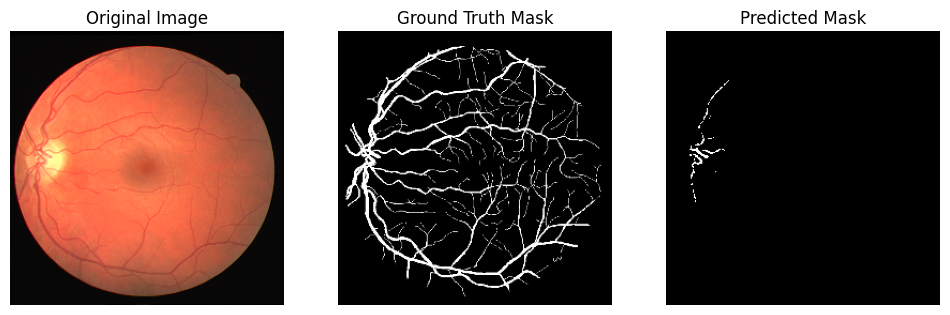

In [46]:
import matplotlib.pyplot as plt

#Function to show prediction results
def show_prediction(index):
    fig, axes = plt.subplots(1, 3, figsize=(12, 4))

    # Original image
    axes[0].imshow(test_images[index])
    axes[0].set_title("Original Image")
    axes[0].axis("off")

    # Ground truth mask
    axes[1].imshow(test_masks[index].squeeze(), cmap="gray")  # ✅ Ensure shape (256, 256)
    axes[1].set_title("Ground Truth Mask")
    axes[1].axis("off")

    # Predicted mask
    pred_mask = model.predict(np.expand_dims(test_images[index], axis=0))  # ✅ Add batch dimension
    pred_mask = (pred_mask > 0.5).astype(np.uint8)  # Threshold
    axes[2].imshow(pred_mask.squeeze(), cmap="gray")  # ✅ Ensure correct shape
    axes[2].set_title("Predicted Mask")
    axes[2].axis("off")

    plt.show()

# Showing a sample prediction
show_prediction(2)

